In [1]:
import pandas as pd
from IPython.core.display import display
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')

In [2]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/cdavidshaffer/CPSC4970-AI/master/data/penguins.csv')
#removing rows with missing values
raw_data = raw_data.replace("?", np.nan)
raw_data.dropna(how="any", inplace=True)
raw_data = raw_data.fillna("", inplace=False)
raw_data.isnull().sum()

display(raw_data.describe())
display(raw_data.info())

#first, converting object type columns to float types to work with data
raw_data["culmen_length_mm"] = pd.to_numeric(raw_data.culmen_length_mm, errors='coerce', downcast='float')
raw_data["culmen_depth_mm"] = pd.to_numeric(raw_data.culmen_depth_mm, errors='coerce', downcast='float')
raw_data["flipper_length_mm"] = pd.to_numeric(raw_data.flipper_length_mm, errors='coerce', downcast='float')
raw_data["body_mass_g"] = pd.to_numeric(raw_data.body_mass_g, errors='coerce', downcast='float')

features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

X = raw_data.loc[:,features].values
Y = raw_data.loc[:,['species']]

display(X)
display(Y)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,334,334,334,334,334,334,334
unique,3,3,163,79,54,93,3
top,Adelie,Biscoe,41.1,17.0,190.0,3800.0,MALE
freq,146,164,7,12,21,12,168


<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   species            334 non-null    object
 1   island             334 non-null    object
 2   culmen_length_mm   334 non-null    object
 3   culmen_depth_mm    334 non-null    object
 4   flipper_length_mm  334 non-null    object
 5   body_mass_g        334 non-null    object
 6   sex                334 non-null    object
dtypes: object(7)
memory usage: 20.9+ KB


None

array([[  39.1,   18.7,  181. , 3750. ],
       [  39.5,   17.4,  186. , 3800. ],
       [  40.3,   18. ,  195. , 3250. ],
       ...,
       [  50.4,   15.7,  222. , 5750. ],
       [  45.2,   14.8,  212. , 5200. ],
       [  49.9,   16.1,  213. , 5400. ]], dtype=float32)

,species
0,Adelie
1,Adelie
2,Adelie
4,Adelie
5,Adelie
...,...
338,Gentoo
340,Gentoo
341,Gentoo
342,Gentoo


X Shape  (334, 4)
X_projected Shape  (334, 2)
pca variance ratio of each component:  [0.68641675 0.1944841 ]


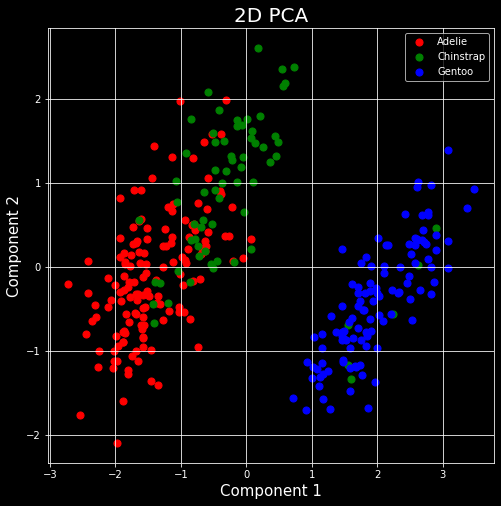

In [3]:
#standardizing the feature data since PCA is sensitive to 'scale'
X_scaled = StandardScaler().fit_transform(X)
print("X Shape ", X_scaled.shape)
#using PCA, projecting 4 numerical features into a 2d space
pca = PCA(n_components=2)

X_projected = pca.fit_transform(X_scaled)
print("X_projected Shape ", X_projected.shape)

components = pd.DataFrame(data = X_projected
             , columns = ['Component 1', 'Component 2'])

plotDf = pd.concat([components, raw_data[['species']]], axis = 1)

#displaying scatter plot of result (using 'target' to set hue)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('2D PCA', fontsize = 20)
targets = ['Adelie', 'Chinstrap', 'Gentoo']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = plotDf['species'] == target
    ax.scatter(plotDf.loc[indicesToKeep, 'Component 1']
               , plotDf.loc[indicesToKeep, 'Component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

print("pca variance ratio of each component: ", pca.explained_variance_ratio_)

In [4]:
print("PCA Components: ", pca.components_)
# sns.heatmap(data=np.abs(pca.components_))

PCA Components:  [[ 0.45330247 -0.39953864  0.57678205  0.5497349 ]
 [ 0.60201806  0.7948507   0.00512046  0.07589799]]


Do the species separate out reasonably well?

- The Gentoo species seperates reasonably well from Adelie and Chinstrap. From the
scatter it appears that Adelie and Chinstrap are still seperated reasonably though
closer together vs Gentoo.

Do the principle components of the numerical features produce a
set of data conducive to cluster analysis that would properly separate
the species into separate clusters?

- Yes, the scatter plot shows clearly distinguishable clusters which tells us that
the observations in the dataset can be grouped.

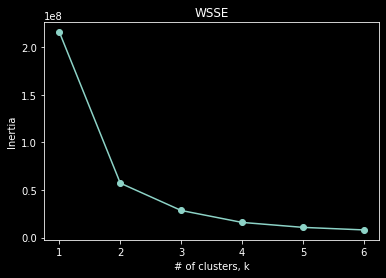

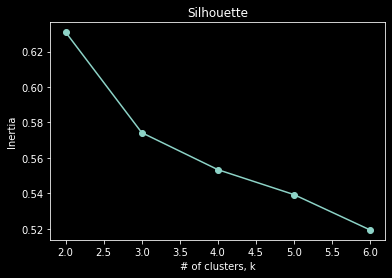

In [5]:
# graph of WSSE and Silhouette scores
wss_values = []
sil_values = []
for k in range(1, 7):
    clusters = KMeans(n_clusters=k).fit(X)
    wss_values.append(clusters.inertia_)
    if k > 1: sil_values.append(silhouette_score(X, clusters.labels_))
plt.xlabel('# of clusters, k')
plt.ylabel('Inertia')
plt.title('WSSE')
plt.plot(range(1, 7), wss_values, '-o')
plt.figure()
plt.xlabel('# of clusters, k')
plt.ylabel('Inertia')
plt.title('Silhouette')
plt.plot(range(2, 7), sil_values, '-o')

Discuss the value of k that would be recommended using those metrics (WSSE, Silhouette
Score)

- Based on the above metrics the value of K that would be recommended from the WSSE
score is 3 clusters ("elbow" shape) the change in he value of the inertia is no
longer significant and neither is the variance of rest of data after the "elbow"
point.
- Regarding the Silhouette scores, the value of K that would be recommended is 3
which is the "maximum" point we look for within the graph to determine the optimal
K value.

K means clustering on the data

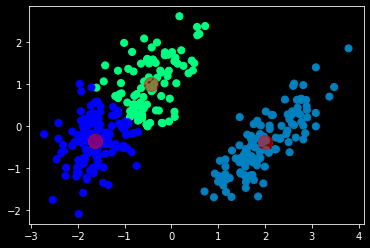

In [6]:
# k-means clustering on the data, given the species separate reasonably well above
kmeans = KMeans(n_clusters=3, random_state=0, init ='k-means++')
kmeans.fit(X_projected)
y_kmeans = kmeans.predict(X_projected)

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y_kmeans, s=50, cmap='winter')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);